# Tabular Playground Series - Nov 21

This month, our data consists of 284 feature variables and our target variable is binary classification. We will first perform some basic EDA to take a better look at this data following which we will start working on our models. 

## Imports 

Let's import some of the libraries we will be using throughout the notebook

In [1]:
# Data Import on Kaggle
import os
import time
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Importing processing libraries
import numpy as np
import pandas as pd

# Importing Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for the metrics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Keras Imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Importing libraries for the model
import xgboost as xgb 
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

# sklearn imports for analysis
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import randint

/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [2]:
data = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv')
test_data = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')

In [3]:
data = data.drop('id', axis=1)

## Memory Reduction

If you don't have any issues with memory, you can go ahead and skip this step. 
Here, we will take a look at the memory consumption by the current data and each feature following which we will try to reduce it to some extent. 

There are several other methods to save RAM - you can refer to this article on [14 tips to save RAM memory](https://www.kaggle.com/pavansanagapati/14-simple-tips-to-save-ram-memory-for-1-gb-dataset). 

In [4]:
memory_usage = data.memory_usage(deep=True) / 1024 ** 2
print('memory usage of features: \n', memory_usage.head(7))
print('memory usage sum: ',memory_usage.sum())

memory usage of features: 
 Index    0.000122
f0       4.577637
f1       4.577637
f2       4.577637
f3       4.577637
f4       4.577637
f5       4.577637
dtype: float64
memory usage sum:  462.3414306640625


In [5]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

data = reduce_memory_usage(data, verbose=True)
test_data = reduce_memory_usage(test_data, verbose=True)

Mem. usage decreased to 115.01 Mb (75.1% reduction)
Mem. usage decreased to 105.06 Mb (74.8% reduction)


In [6]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
count,600000.000000,600000.000000,600000.0000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.059357,NaN,0.106689,NaN,NaN,NaN,NaN,0.506010
std,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.119446,0.000000,0.209106,0.000000,0.000000,0.000000,0.000000,0.499964
min,-3.796875,-1.223633,-1843.0000,-1.368164,-3.207031,-1.169922,-1.059570,-1.282227,-1.242188,-2.578125,...,-1.217773,-9.765625,-4.667969,-3.101562,-1.276367,-1.584961,-1.254883,-3.994141,-2.783203,0.000000
25%,0.026215,1.186523,43.5625,1.442383,0.019714,1.260742,1.385742,1.333984,1.291992,0.019562,...,1.213867,0.018906,0.024490,0.017059,0.025467,1.248047,1.347656,0.013535,0.018112,0.000000
50%,0.097778,2.515625,133.6250,2.634766,0.061584,2.589844,2.800781,2.558594,2.476562,0.058746,...,2.386719,0.068909,0.056641,0.063416,0.062164,2.601562,2.681641,0.058044,0.058472,1.000000
75%,0.397217,3.787109,302.2500,3.908203,0.112732,3.814453,3.996094,3.824219,3.804688,0.101074,...,3.693359,0.125122,0.088135,0.113098,0.101990,3.820312,3.839844,0.110718,0.104858,1.000000
max,8.781250,6.226562,6120.0000,6.519531,8.265625,6.515625,6.585938,6.257812,6.390625,7.078125,...,6.574219,18.406250,10.210938,8.625000,3.656250,6.253906,6.144531,10.765625,5.988281,1.000000


## Sampling Data

Now that we have reduced the memory usage by over 70%, let's sample the data. 

Why are we doing this? Well, you don't have to. But if you're like me and own a Macbook Air that can't handle a dataset bigger than 100mb, this might be a good idea.

When we are performing model selection and hyperparameter tuning later, we can't afford to let the notebook run for hours on end testing every model. Doing this, preserves the distributions of each feature while taking only 20% of the entire dataset and we can reduce the training time by using this sampled data.

We can then perform EDA, modelling, hyperparameter tuning and other steps on this sampled data. Once we decide on the model we want to use and improve its performance, we can train the final model on the entire dataset again.

In [7]:
sample_df = data.sample(int(len(data) * 0.2))
sample_df.shape

(120000, 101)

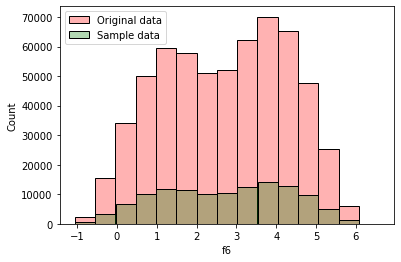

In [8]:
# Let's confirm if the sampling is retaining the feature distributions

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=data, x="f6", label="Original data", color="red", alpha=0.3, bins=15
)
sns.histplot(
    data=sample_df, x="f6", label="Sample data", color="green", alpha=0.3, bins=15
)

plt.legend()
plt.show();

# Data Prep

In [9]:
# features = data.columns
# scale = MinMaxScaler()
# sample_df[features]=scale.fit_transform(sample_df[features])
# sample_df[features]= scale.transform(sample_df[features])  

# print('Data scaled using : ', scale)

In [10]:
X = sample_df.drop('target', axis=1)
y = sample_df.target
del sample_df # we do this to remove sample_df from memory

In [11]:
test_data = test_data.drop('id', axis=1)
tt = test_data.values

In [12]:
model = Sequential([
    Flatten(input_shape=(100,)),
    Dense(100, activation=tf.nn.swish),
    Dense(64, activation=tf.nn.swish),
    Dense(32, activation=tf.nn.swish),
    Dense(16, activation=tf.nn.swish),
    Dense(1, activation=tf.nn.sigmoid),
])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [13]:
from sklearn.model_selection import KFold

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

test_predictions_nn = np.zeros(test_data.shape[0])


scores_folds = {}
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds['NN'] = []
counter = 1


for fold, (trn_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[trn_ind][:], X.iloc[val_ind][:]
    y_train, y_test = y.iloc[trn_ind], y.iloc[val_ind]
    print('CV {}/{}'.format(counter, n_folds)) 


    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])
    model.fit(X_train, 
              y_train, 
              epochs=1000, 
              batch_size=2048, 
              validation_data=(X_test, y_test), 
              callbacks=[es, plateau],
              validation_batch_size=1000,
              shuffle=True,
              verbose = 1)
    
    preds = model.predict(X_test).reshape(1,-1)[0]
    score = round(roc_auc_score(y_test, preds),5)
    print('Fold {} {}: {}'.format(counter, 'NN', score))
    scores_folds['NN'].append(score)
    test_predictions_nn += model.predict([tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds       
    counter += 1

Training fold 1
CV 1/5


2021-11-01 17:16:32.460387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
47/47 [==============================] - 2s 20ms/step - loss: 0.8714 - auc: 0.5113 - val_loss: 0.6928 - val_auc: 0.5420
Epoch 2/1000
47/47 [==============================] - 1s 11ms/step - loss: 0.6841 - auc: 0.5848 - val_loss: 0.6719 - val_auc: 0.6300
Epoch 3/1000
47/47 [==============================] - 1s 11ms/step - loss: 0.6520 - auc: 0.6722 - val_loss: 0.6364 - val_auc: 0.7021
Epoch 4/1000
47/47 [==============================] - 1s 12ms/step - loss: 0.6320 - auc: 0.7075 - val_loss: 0.6271 - val_auc: 0.7179
Epoch 5/1000
47/47 [==============================] - 1s 11ms/step - loss: 0.6265 - auc: 0.7172 - val_loss: 0.6199 - val_auc: 0.7275
Epoch 6/1000
47/47 [==============================] - 1s 11ms/step - loss: 0.6183 - auc: 0.7285 - val_loss: 0.6162 - val_auc: 0.7327
Epoch 7/1000
47/47 [==============================] - 1s 11ms/step - loss: 0.6177 - auc: 0.7286 - val_loss: 0.6457 - val_auc: 0.7094
Epoch 8/1000
47/47 [==============================] - 1s 11ms/step - 

In [14]:
sub=pd.read_csv("../input/tabular-playground-series-nov-2021/sample_submission.csv")
sub['target']=test_predictions_nn

In [15]:
sub

,id,target
0,600000,0.737877
1,600001,0.747742
2,600002,0.816306
3,600003,0.339011
4,600004,0.751990
...,...,...
539995,1139995,0.795158
539996,1139996,0.847601
539997,1139997,0.576607
539998,1139998,0.696465


In [16]:
sub.to_csv("nn_submission2.csv",index=False)